#### Import packages

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import  LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

#### Ingest data

In [3]:
df = pd.read_csv('Key Biscayne 2000-2022.csv')
df.head()

,ML#,Full_Address,Unit_Number,Latitude,Longitude,List_Date,Closing_Date,Days_on_Market,List_Price,Sale_Price,Pool_YN,Property_Type,Waterfront_Property,Year_Built,SP$_LP$,LP$_SqFt,SP$_SqFt,SqFt_Liv_Area,Num_Beds,Full_Baths,Half_Baths,NumGarage_Spaces,Street_Number,Street_Name,City_Name,State,Zip_Code,Status
0,A1712185,"100 SUNRISE DR. Key Biscayne, FL 33149",16,25.689898,-80.163071,11/9/2012,2/27/2013,3.0,104900.0,104900,0,Condo/Co-Op/Villa/Townhouse,0.0,1964,1.00,255.85,255.85,410,0,1,0,0,100,SUNRISE DR,Key Biscayne,FL,33149,Closed
1,M1450739,"100 SUNRISE DR. Key Biscayne, FL 33149",10,25.689898,-80.163071,12/9/2010,3/24/2011,27.0,104900.0,95900,0,Condo/Co-Op/Villa/Townhouse,0.0,1964,0.91,197.92,180.94,530,1,1,0,0,100,SUNRISE DR,Key Biscayne,FL,33149,Closed
2,A1604162,"325 FERNWOOD RD. Key Biscayne, FL 33149",3,25.695277,-80.164117,2/9/2012,4/25/2012,27.0,109900.0,140000,0,Condo/Co-Op/Villa/Townhouse,0.0,1955,1.27,231.86,295.36,474,1,1,0,0,325,FERNWOOD RD,Key Biscayne,FL,33149,Closed
3,M1418025,"100 SUNRISE DR. Key Biscayne, FL 33149",8,25.689898,-80.163071,9/10/2010,11/17/2010,15.0,110200.0,100000,0,Condo/Co-Op/Villa/Townhouse,0.0,1964,0.91,172.19,156.25,640,2,1,0,0,100,SUNRISE DR,Key Biscayne,FL,33149,Closed
4,M1461840,"100 SUNRISE DR. Key Biscayne, FL 33149",35,25.689898,-80.163071,1/15/2011,2/28/2011,11.0,124900.0,110000,0,Condo/Co-Op/Villa/Townhouse,0.0,1964,0.88,235.66,207.55,530,1,1,0,0,100,SUNRISE DR,Key Biscayne,FL,33149,Closed


#### Preprocess data

In [4]:
def filter_df(df):
    temp = df.copy()
    temp = temp[temp['Days_on_Market'].notna()]
    temp = temp[temp['List_Price'].notna()]
    temp = temp[temp['Waterfront_Property'].notna()]
    temp = temp.reset_index(drop=True)
    return temp

def remove_extra(str):
    return str.replace("..",".")

def reformat_address(temp):
    temp['Full_Address'] = temp['Full_Address'].str.upper()
    repl = {'BOULEVARD':'BL','BLVD':'BL','CIRCLE':'CR','CIR':'CR','DRIVE':'DR','LANE':'LN','POINT':'PT','WALK':'WK'}
    repl = {rf'\b{k}\b': v for k, v in repl.items()}
    Addy_Reform = temp['Full_Address'].replace(repl, regex=True).to_list()
    temp['Full_Address'] = [remove_extra(str) for str in Addy_Reform]
    return temp

In [5]:
temp = filter_df(df)
temp = reformat_address(temp)

#### Feature engineering

In [6]:
def compute_price_diff(temp):
    temp['Price_Diff'] = temp['List_Price'] - temp['Sale_Price']
    return temp

def num_times_sold(temp):
    address = temp.groupby('Full_Address')['Full_Address'].count().index
    count = temp.groupby('Full_Address')['Full_Address'].count().values
    temp_list = []
    for i in range(len(temp)):
        temp_address = temp['Full_Address'].iloc[i]
        temp_list.append(int(count[address==temp_address]))
    temp['Times_Sold'] = temp_list
    return temp

def average_days_on_market(temp):
    temp['Avg_DOM'] = temp['Days_on_Market']/temp['Times_Sold']
    return temp

def compute_age_of_property(temp):
    temp['Closing_Date'] = pd.to_datetime(temp['Closing_Date'])
    temp['Sell_Year'] = temp['Closing_Date'].dt.year
    temp['Years_Old'] = temp['Sell_Year'] - temp['Year_Built'].astype('int64')  
    return temp

In [24]:
temp = compute_price_diff(temp)
temp = num_times_sold(temp)
temp = average_days_on_market(temp)
temp = compute_age_of_property(temp)

temp.to_csv("Output.csv", index = False)

temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4606 entries, 0 to 4605
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ML#                  4606 non-null   object        
 1   Full_Address         4606 non-null   object        
 2   Unit_Number          3657 non-null   object        
 3   Latitude             4606 non-null   float64       
 4   Longitude            4606 non-null   float64       
 5   List_Date            4606 non-null   object        
 6   Closing_Date         4606 non-null   datetime64[ns]
 7   Days_on_Market       4606 non-null   float64       
 8   List_Price           4606 non-null   float64       
 9   Sale_Price           4606 non-null   int64         
 10  Pool_YN              4606 non-null   int64         
 11  Property_Type        4606 non-null   object        
 12  Waterfront_Property  4606 non-null   float64       
 13  Year_Built           4606 non-nul

#### Descriptive Visualization

In [8]:
all_property = temp.select_dtypes(include=['number']).drop(columns=['Latitude','Longitude','Year_Built','Pool_YN','List_Price','Street_Number','SP$_SqFt','LP$_SqFt','SP$_LP$']).dropna()
all_property['Sale_Price'] = np.log10(all_property['Sale_Price'].to_numpy())
waterfront = all_property[all_property['Waterfront_Property']==1].drop(columns=['Waterfront_Property'])
non_waterfront = all_property[~(all_property['Waterfront_Property']==1)].drop(columns=['Waterfront_Property'])
all_property_corr = all_property.corr()
water_corr = waterfront.corr()
non_water_corr = non_waterfront.corr()

In [9]:
#log percentiles
percentiles = np.array([2.5,25,50,75,97.5])
all_prop_percentiles = np.percentile(all_property['Sale_Price'],percentiles)
WF_prop_percentiles = np.percentile(waterfront['Sale_Price'],percentiles)
NWF_prop_percentiles = np.percentile(non_waterfront['Sale_Price'],percentiles)

#Raise log for legend - need to reformat scientific notation
APP_leg = np.array([10]*5)**all_prop_percentiles
WFP_leg = np.array([10]*5)**WF_prop_percentiles
NWFP_leg = np.array([10]*5)**NWF_prop_percentiles


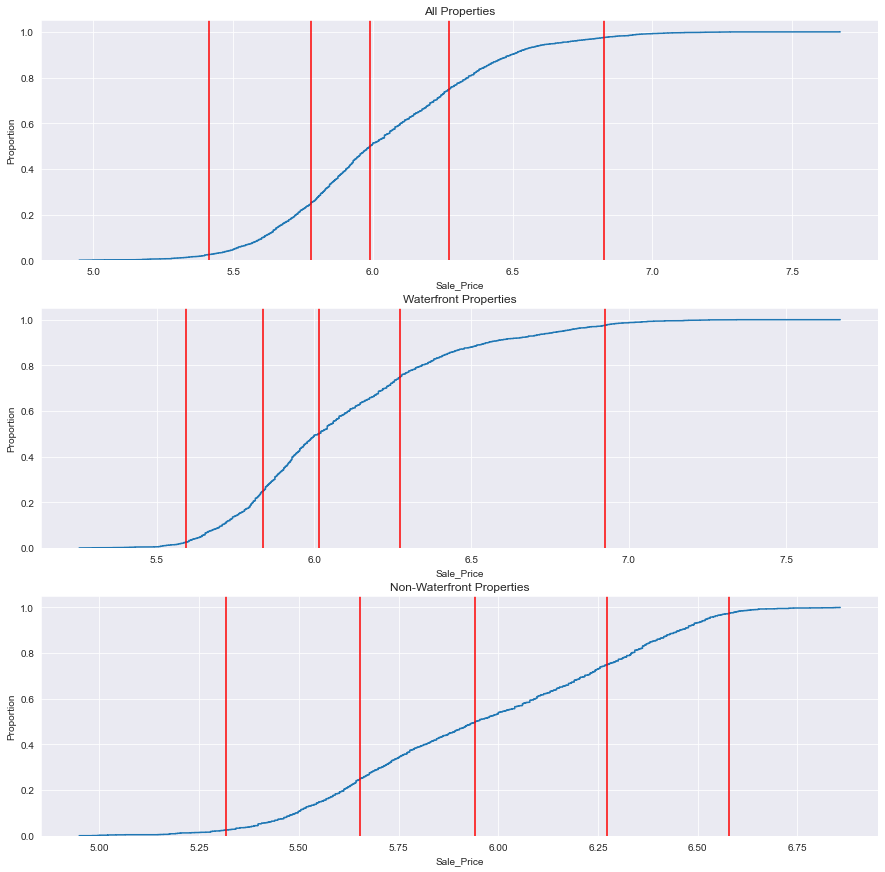

6.857332496431268
7.672097857935717
7.672097857935717


In [10]:
fig, (ax,ax1,ax2) = plt.subplots(3,figsize=(15,15))
sns.ecdfplot(all_property,x='Sale_Price',ax=ax)
ax.axvline(all_prop_percentiles[0], color = "r")
ax.axvline(all_prop_percentiles[1], color = "r")
ax.axvline(all_prop_percentiles[2], color = "r")
ax.axvline(all_prop_percentiles[3], color = "r")
ax.axvline(all_prop_percentiles[4], color = "r")
ax.set_title('All Properties')
ax.set_ylim([0,1.05])
sns.ecdfplot(waterfront,x='Sale_Price',ax=ax1)
ax1.axvline(WF_prop_percentiles[0], color = "r")
ax1.axvline(WF_prop_percentiles[1], color = "r")
ax1.axvline(WF_prop_percentiles[2], color = "r")
ax1.axvline(WF_prop_percentiles[3], color = "r")
ax1.axvline(WF_prop_percentiles[4], color = "r")
ax1.set_title('Waterfront Properties')
ax1.set_ylim([0,1.05])
sns.ecdfplot(non_waterfront,x='Sale_Price',ax=ax2)
ax2.axvline(NWF_prop_percentiles[0], color = "r")
ax2.axvline(NWF_prop_percentiles[1], color = "r")
ax2.axvline(NWF_prop_percentiles[2], color = "r")
ax2.axvline(NWF_prop_percentiles[3], color = "r")
ax2.axvline(NWF_prop_percentiles[4], color = "r")
ax2.set_title('Non-Waterfront Properties')
ax2.set_ylim([0,1.05])
plt.show()
print(non_waterfront['Sale_Price'].max())
print(waterfront['Sale_Price'].max())
print(all_property['Sale_Price'].max())

In [11]:
df['Sale_Price'].describe()

count    4.688000e+03
mean     1.580287e+06
std      1.889829e+06
min      8.900000e+04
25%      6.000000e+05
50%      9.895000e+05
75%      1.890000e+06
max      4.700000e+07
Name: Sale_Price, dtype: float64

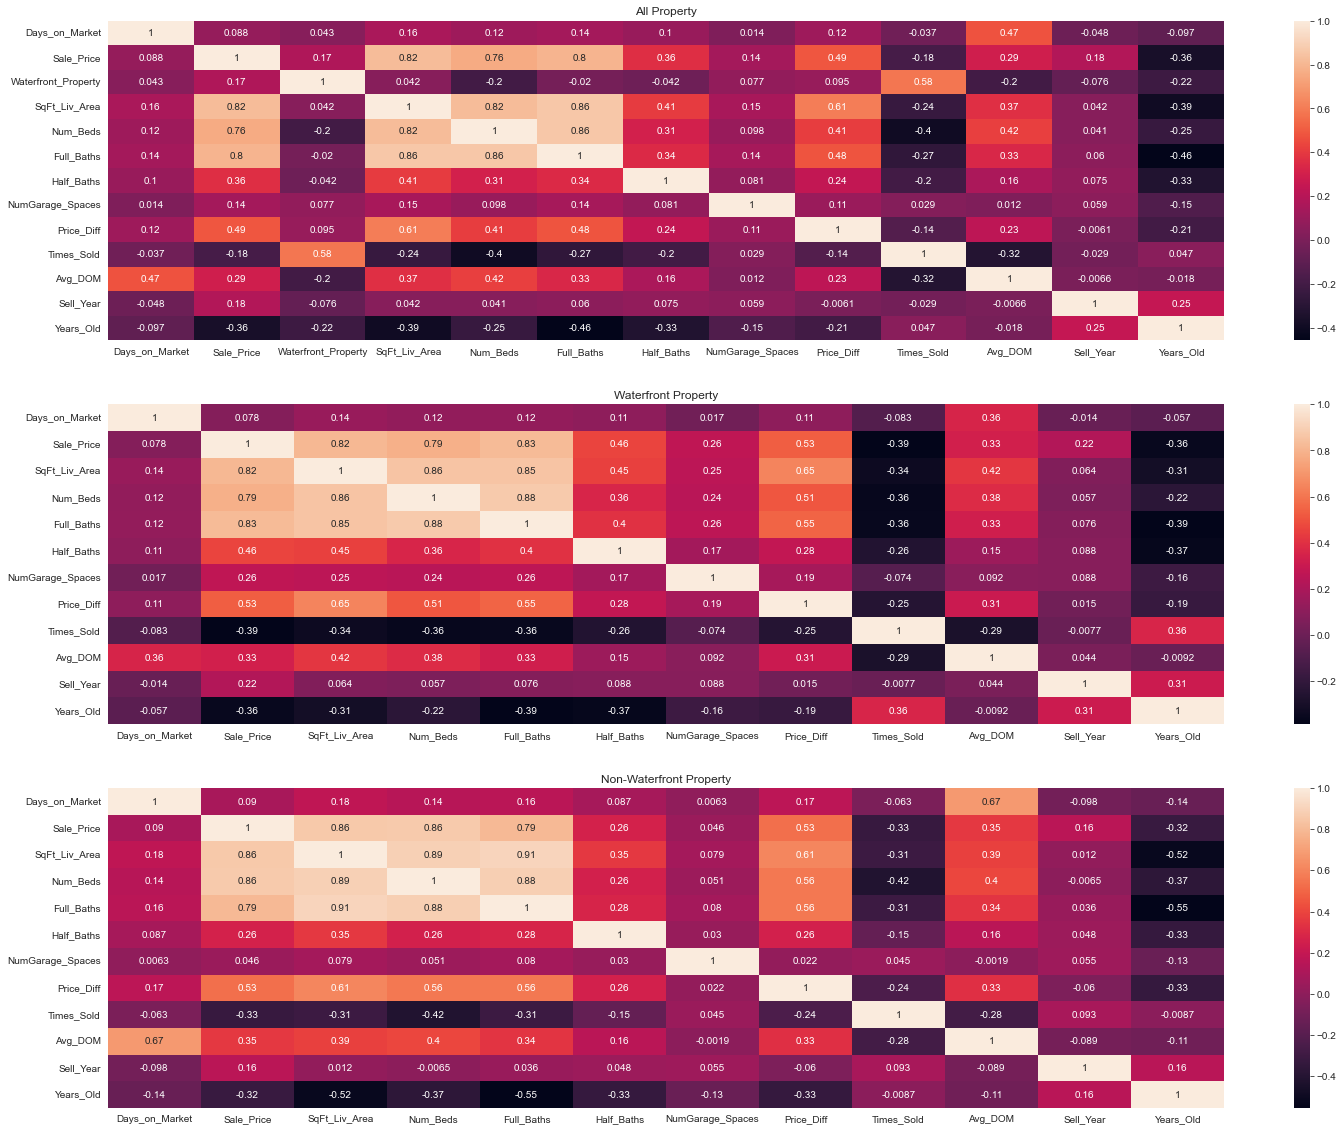

In [12]:
df['Sale_Price'].describe()
fig, (ax, ax1, ax2) = plt.subplots(3, figsize=(25, 20))
sns.heatmap(all_property_corr, annot=True, ax=ax)
ax.set_title('All Property')
sns.heatmap(water_corr, annot=True, ax=ax1)
ax1.set_title('Waterfront Property')
sns.heatmap(non_water_corr, annot=True, ax=ax2)
ax2.set_title('Non-Waterfront Property')
plt.show()

#### Build model

In [13]:
#Transform Vars
model_avg_dom = minmax_scale(np.log(temp['Avg_DOM']))
model_pool = temp['Pool_YN'].to_numpy()
model_multi_home = pd.get_dummies(temp['Property_Type'])['Condo/Co-Op/Villa/Townhouse'].to_numpy()
model_single_home = pd.get_dummies(temp['Property_Type'])['Single Family'].to_numpy()
model_waterfront = temp['Waterfront_Property'].astype(int).to_numpy()
model_sqft_living = np.log(temp['SqFt_Liv_Area']).to_numpy()
model_num_beds = temp['Num_Beds'].to_numpy()
model_full_bath = temp['Full_Baths'].to_numpy()
model_half_bath = temp['Half_Baths'].to_numpy()
model_num_garage = temp['NumGarage_Spaces'].to_numpy()
model_num_times_sold = temp['Times_Sold'].to_numpy()
model_years_old = temp['Years_Old'].to_numpy()

In [14]:
#Load predictors & target
y = np.log(temp['Sale_Price'].to_numpy())
X = np.concatenate((model_avg_dom.reshape(-1,1),
                    model_pool.reshape(-1,1),
                    model_multi_home.reshape(-1,1),
                    model_single_home.reshape(-1,1),
                    model_waterfront.reshape(-1,1),
                    model_sqft_living.reshape(-1,1),
                    model_num_beds.reshape(-1,1),
                    model_full_bath.reshape(-1,1),
                    model_half_bath.reshape(-1,1),
                    model_num_garage.reshape(-1,1),
                    model_num_times_sold.reshape(-1,1),
                    model_years_old.reshape(-1,1)),
                    axis=1)

In [15]:
#Drop NaNs
mask = np.isnan(X).sum(1)==0
X = X[mask]
y = y[mask]

In [16]:
#Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69420)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3224, 12)
(3224,)
(1382, 12)
(1382,)


#### Linear Regression

R^2: 0.825
RMSE: 0.3499


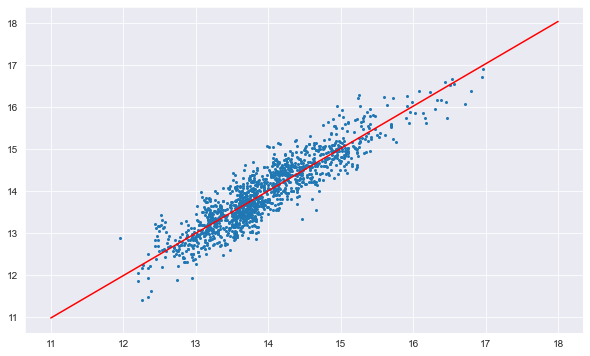

In [17]:
linear_model = LinearRegression().fit(X_train, y_train)
y_hat = linear_model.predict(X_test)
r_2 = r2_score(y_test, y_hat)
rmse = np.sqrt(np.mean((y_test - y_hat)**2))

print('R^2:', r_2.round(4))
print('RMSE:', rmse.round(4))
plt.figure(figsize=(10,6))
plt.plot(y_hat, y_test, 'o', ms=2)
m,b = np.polyfit(y_hat, y_test, 1)
x = np.linspace(11,18,100)
plt.plot(x, m*x+b, c='r')
plt.show()

#### Decision Tree

R^2: 0.8461
RMSE: 0.3282


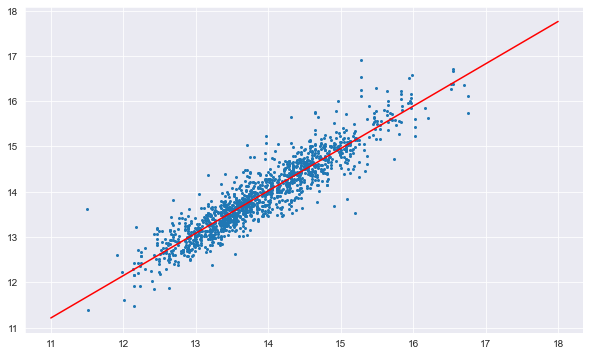

In [18]:
tree_model = DecisionTreeRegressor().fit(X_train, y_train)
y_hat = tree_model.predict(X_test)
r_2 = r2_score(y_test, y_hat)
rmse = np.sqrt(np.mean((y_test - y_hat)**2))

print('R^2:', r_2.round(4))
print('RMSE:', rmse.round(4))
plt.figure(figsize=(10,6))
plt.plot(y_hat, y_test, 'o', ms=2)
m,b = np.polyfit(y_hat, y_test, 1)
x = np.linspace(11,18,100)
plt.plot(x, m*x+b, c='r')
plt.show()

In [19]:
plt.figure(figsize=(10,6))


<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

#### Multi-layer Perception Regressor

R^2: 0.6566
RMSE: 0.4902


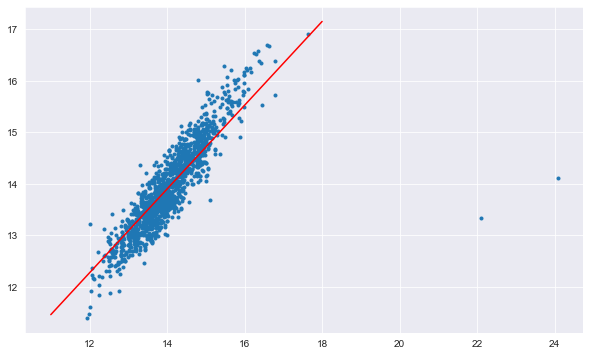

In [20]:
mlp_model = MLPRegressor().fit(X_train, y_train)
y_hat = mlp_model.predict(X_test)
r_2 = r2_score(y_test, y_hat)
rmse = np.sqrt(np.mean((y_test - y_hat)**2))

print('R^2:', r_2.round(4))
print('RMSE:', rmse.round(4))
plt.figure(figsize=(10,6))
plt.plot(y_hat, y_test, 'o', ms=3)
m,b = np.polyfit(y_hat,y_test, 1)
x = np.linspace(11,18,100)
plt.plot(x, m*x+b, c='r')
plt.show()

In [21]:
print(y_hat)

[13.50380352 15.40530681 14.57896276 ... 13.28400636 14.28399262
 14.60106075]
